In [1]:
from __future__ import print_function
import random
import time
import os
import logging
from timeit import default_timer as timer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib
import numpy as np

## Torch
import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F
import torch.optim as optim

from src.logger_v1 import setup_logs

run_name = "cdc" + time.strftime("-%Y-%m-%d_%H_%M_%S")
print(run_name)
logging_dir = 'snapshot/cdc/'
logger = setup_logs(logging_dir, run_name) # setup logs

cdc-2021-04-01_16_38_04


In [2]:
def rolling_window(a, window):
    shape =  (a.shape[0] - window + 1, window) + a.shape[1:]
    strides = (a.strides[0],) + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides, writeable = False)

In [3]:
class ScheduledOptim(object):
    """A simple wrapper class for learning rate scheduling"""

    def __init__(self, optimizer, n_warmup_steps):
        self.optimizer = optimizer
        self.d_model = 128 
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0 
        self.delta = 1

    def state_dict(self):
        self.optimizer.state_dict()

    def step(self):
        """Step by the inner optimizer"""
        self.optimizer.step()

    def zero_grad(self):
        """Zero out the gradients by the inner optimizer"""
        self.optimizer.zero_grad()

    def increase_delta(self):
        self.delta *= 2

    def update_learning_rate(self):
        """Learning rate scheduling per step"""

        self.n_current_steps += self.delta
        new_lr = np.power(self.d_model, -0.5) * np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = new_lr
        return new_lr

In [4]:
class TETrainDataset(data.Dataset):
    def __init__(self, fault=list(range(1,21)), window=20):
        """ fault: [1,2,3,4,5,6]
            window: 20
        """
        self.window = window 
        temp = torch.from_numpy(rolling_window(np.loadtxt('data/d00.dat').T, window))
        self.sample = [temp]
        self.label = [0 for _ in temp]

        for label in fault:
            if label < 10:
                num = '0' + str(label)
            else:
                num = str(label)
            temp = rolling_window(np.loadtxt('data/d' + num + '.dat'), window)
            self.sample.append(temp)
            self.label.extend([label for _ in temp])
        
        self.sample = np.concatenate(self.sample,0)
        
        if os.path.exists('./scalar'):
            std = joblib.load('./scalar')
            sh = self.sample.shape
            self.sample = std.transform(self.sample.reshape(-1,sh[-1])).reshape(sh)
        else:
            std = StandardScaler()
            sh = self.sample.shape
            std.fit(self.sample.reshape(-1,sh[-1]))
            self.sample = std.transform(self.sample.reshape(-1,sh[-1])).reshape(sh)
            joblib.dump(std, './scalar')
        
        self.sample = torch.from_numpy(self.sample).float()
        self.label = torch.tensor(self.label).float()
        assert self.sample.shape[0] == self.label.shape[0]
        
    def __len__(self):
        return len(self.sample)

    def __getitem__(self, index):
        return self.sample[index], self.label[index]

class TETestDataset(data.Dataset):
    def __init__(self, fault=list(range(1,21)), window=20):
        """ fault: [1,2,3,4,5,6]
            window: 20
        """
        self.window = window 
        temp = torch.from_numpy(rolling_window(np.loadtxt('data/d00_te.dat'), window))
        self.sample = [temp]
        self.label = [0 for _ in temp]

        for label in fault:
            if label < 10:
                num = '0' + str(label)
            else:
                num = str(label)
            temp = rolling_window(np.loadtxt('data/d' + num + '_te.dat'), window)
            self.sample.append(temp)
            if window <= 160:
                self.label.extend([0 for _ in range(160-window+1)])
                self.label.extend([label for _ in range(800)])
            else:
                self.label.extend([label for _ in range(960-window+1)])
        
        self.sample = np.concatenate(self.sample,0)
        
        if os.path.exists('./scalar'):
            std = joblib.load('./scalar')
            sh = self.sample.shape
            self.sample = std.transform(self.sample.reshape(-1,sh[-1])).reshape(sh)
        else:
            std = StandardScaler()
            sh = self.sample.shape
            std.fit(self.sample.reshape(-1,sh[-1]))
            self.sample = std.transform(self.sample.reshape(-1,sh[-1])).reshape(sh)
            joblib.dump(std, './scalar')
        
        self.sample = torch.from_numpy(self.sample).float()
        self.label = torch.tensor(self.label).float()
        assert self.sample.shape[0] == self.label.shape[0]
        
    def __len__(self):
        return len(self.sample)

    def __getitem__(self, index):
        return self.sample[index], self.label[index]

In [5]:
class CPC_GRU(nn.Module):
    def __init__(self, input_size, low_size, high_size, num_layers, timestep, batch_size, seq_len):

        super(CPC_GRU, self).__init__()

        self.batch_size = batch_size
        self.seq_len = seq_len
        self.timestep = timestep
        self.input_size = input_size
        self.low_size = low_size
        self.high_size = high_size
        self.num_layers = num_layers
        self.encoder = nn.Sequential( # downsampling factor = 160
            nn.Linear(self.input_size,self.low_size, bias=False),
            nn.BatchNorm1d(self.seq_len+self.timestep),
            nn.ReLU(inplace=True),
            nn.Linear(self.low_size, self.low_size, bias=False),
            nn.BatchNorm1d(self.seq_len+self.timestep),
            nn.ReLU(inplace=True),
        )
        self.gru = nn.GRU(self.low_size, self.high_size, num_layers=self.num_layers, bidirectional=False, batch_first=True)
        self.Wk  = nn.ModuleList([nn.Linear(self.high_size, self.low_size) for i in range(timestep)])
        self.softmax  = nn.Softmax()
        self.lsoftmax = nn.LogSoftmax()

        def _weights_init(m):
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # initialize gru
        for layer_p in self.gru._all_weights:
            for p in layer_p:
                if 'weight' in p:
                    nn.init.kaiming_normal_(self.gru.__getattr__(p), mode='fan_out', nonlinearity='relu')

        self.apply(_weights_init)

    def init_hidden(self, batch_size, use_gpu=True):
        if use_gpu: return torch.zeros(self.num_layers, batch_size, self.high_size).cuda()
        else: return torch.zeros(self.num_layers, batch_size, self.high_size)

    def forward(self, x, hidden):
        batch = x.size()[0]
        z = self.encoder(x)

        encode_samples = z[:,-1*self.timestep:,:].transpose(0,1)
       
        nce = 0 # average over timestep and batch
        forward_seq = z[:,:self.seq_len,:] 
        output, hidden = self.gru(forward_seq, hidden) 
        c_t = output[:,-1,:].view(batch, -1) 
        pred = torch.empty((self.timestep,batch,32)).float().to(x.device) 
        for i in np.arange(0, self.timestep):
            pred[i] = self.Wk[i](c_t) 
        for i in np.arange(0, self.timestep):
            total = torch.mm(encode_samples[i], torch.transpose(pred[i],0,1)) # e.g. size 8*8
            correct = torch.sum(torch.eq(torch.argmax(self.softmax(total), dim=0).cpu(), torch.arange(0, batch))) # correct is a tensor
            nce += torch.sum(torch.diag(self.lsoftmax(total))) # nce is a tensor
        nce /= -1.*batch*self.timestep
        accuracy = 1.*correct.item()/batch

        return accuracy, nce

    def predict(self, x, hidden):
        batch = x.size()[0]
       
        z = self.encoder(x)
        
        # z = z.transpose(1,2)
        output, _ = self.gru(z, hidden) 

        return output[:,-1,:].view(batch, -1) 
        

In [6]:
def train(model, device, train_loader, optimizer, epoch, batch_size, log_interval):
    model.train()
    total_loss = 0
    total_acc  = 0 
    for batch_idx, data_use in enumerate(train_loader):
        seq, label = data_use
        seq, label = seq.to(device), label.to(device)
        optimizer.zero_grad()
        hidden = model.init_hidden(len(seq), use_gpu=True)
        acc, loss = model(seq, hidden)
        total_loss += len(seq) * loss 
        total_acc  += len(seq) * acc

        loss.backward()
        optimizer.step()
        lr = optimizer.update_learning_rate()
        if batch_idx % log_interval == 0:
            logger.info('Train Epoch: {} [{}/{} ({:.0f}%)]\tlr:{:.5f}\tAccuracy: {:.4f}\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data_use), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), lr, acc, loss.item()))
    total_loss /= len(train_loader.dataset) # average loss
    total_acc  /= len(train_loader.dataset) # average acc
    return total_acc, total_loss

def validation(model, device, data_loader, batch_size):
    logger.info("Starting Validation")
    model.eval()
    total_loss = 0
    total_acc  = 0 

    with torch.no_grad():
        for data_use in data_loader:
            seq, label = data_use
            seq, label = seq.to(device), label.to(device)
            hidden = model.init_hidden(len(seq), use_gpu=True)
            acc, loss = model(seq, hidden)
            total_loss += len(seq) * loss 
            total_acc  += len(seq) * acc

    total_loss /= len(data_loader.dataset) # average loss
    total_acc  /= len(data_loader.dataset) # average acc

    logger.info('===> Validation set: Average loss: {:.4f}\tAccuracy: {:.4f}\n'.format(
                total_loss, total_acc))

    # return total_acc, total_loss

def predict(model, device, train_loader, test_loader, batch_size):
    logger.info("Starting predict")
    model.eval()

    trains, trains_labels = [], []
    with torch.no_grad():
        for data_use in train_loader:
            seq, label = data_use
            seq, label = seq.to(device), label.to(device)
            hidden = model.init_hidden(len(seq), use_gpu=True)
            feature = model.predict(seq, hidden)
            trains.append(feature)
            trains_labels.append(label)
    train_data = data.TensorDataset(torch.cat(trains, axis=0), torch.cat(trains_labels, axis=0))

    tests, tests_labels = [], []
    with torch.no_grad():
        for data_use in test_loader:
            seq, label = data_use
            seq, label = seq.to(device), label.to(device)
            hidden = model.init_hidden(len(seq), use_gpu=True)
            feature = model.predict(seq, hidden)
            tests.append(feature)
            tests_labels.append(label)
    test_data = data.TensorDataset(torch.cat(tests, axis=0), torch.cat(tests_labels, axis=0))

    return  data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory), data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

def snapshot(dir_path, run_name, state):
    snapshot_file = os.path.join(dir_path,
                    run_name + '-model_best.pth')
    torch.save(state, snapshot_file)
    logger.info("Snapshot saved to {}\n".format(snapshot_file))

In [33]:
def model_data(fault_test=list(range(1,21)), fault_train=list(range(1,21))):
    model = CPC_GRU(input_size=52, low_size=32, high_size=16, num_layers=2, timestep=timestep, batch_size=batch_size, seq_len=window).to(device)

    logger.info('===> loading train and eval dataset')
    training_set   = TETrainDataset(fault=fault1,window=window+timestep)
    test_set = TETestDataset(fault=fault_test,window=window+timestep)

    train_loader = data.DataLoader(training_set, batch_size=batch_size, shuffle=True,
     num_workers=num_workers, pin_memory=pin_memory) # set shuffle to True
    test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, 
    num_workers=num_workers, pin_memory=pin_memory) # set shuffle to False
    
    optimizer = ScheduledOptim(
        optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()), 
            betas=(0.9, 0.98), eps=1e-09, weight_decay=1e-4, amsgrad=True),
        n_warmup_steps)

    model_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    logger.info('### Model summary below###\n {}\n'.format(str(model)))
    logger.info('===> Model total parameter: {}\n'.format(model_params))

    return model, train_loader, test_loader, optimizer

In [34]:
def process():
    ## Start training
    best_acc = 0
    best_loss = np.inf
    best_epoch = -1 
    feature_train_loader, feature_test_loader = None, None
    for epoch in range(1, epochs + 1):
        epoch_timer = timer()

        # Train and validate
        val_acc, val_loss = train(model, device, train_loader, optimizer, epoch, batch_size, log_interval)
        validation(model, device, test_loader, batch_size)
        
        # Save
        if val_acc > best_acc: 
            best_acc = max(val_acc, best_acc)
            snapshot(logging_dir, run_name, {
                'epoch': epoch + 1,
                'validation_acc': val_acc, 
                'state_dict': model.state_dict(),
                'validation_loss': val_loss,
                'optimizer': optimizer.state_dict(),

            })
            best_epoch = epoch + 1
            feature_train_loader, feature_test_loader = predict(model, device, train_loader, test_loader, batch_size)
        elif epoch - best_epoch > 2:
            optimizer.increase_delta()
            best_epoch = epoch + 1
        
        end_epoch_timer = timer()
        logger.info("#### End epoch {}/{}, elapsed time: {}".format(epoch, epochs, end_epoch_timer - epoch_timer))

    ## end 
    end_global_timer = timer()
    logger.info("################## Success #########################")
    logger.info("Total elapsed time: %s" % (end_global_timer - global_timer))
    return feature_train_loader, feature_test_loader 

In [35]:
def show_by_PCA(lis):
    a = len(lis)
    if a <=17:
        x = []
        for i in lis:
            x = x + i
        pca = PCA(n_components=2)     #加载PCA算法，设置降维后主成分数目为2
        reduced_x = pca.fit_transform(x)  # 对样本进行降维
        lenall = 0
        colors = ['k','r','y','g','c','b','m','grey','maroon','tan','gold','lime','lightbiue','navy','blueviolet','violet','pink']
        fig = plt.figure()
        for i in range(a):
            length = len(lis[i]) + lenall
            plt.scatter(reduced_x[lenall:length,0], reduced_x[lenall:length,1], c=colors[i], marker='x')
            lenall = length
        plt.show()
    else:
        print('Too many categories to display or n is fault')

def show_fault(train,test,num):
    for i in num:
        tmp0 = train.dataset.sample[train.dataset.label==0][:,-1,:].tolist()
        tmpi = train.dataset.sample[train.dataset.label==i][:,-1,:].tolist()
        show_by_PCA([tmp0,tmpi])
        tmp0 = test.dataset.sample[test.dataset.label==0][:,-1,:].tolist()
        tmpi = test.dataset.sample[test.dataset.label==i][:,-1,:].tolist()
        show_by_PCA([tmp0,tmpi])

def show_feature_fault(train,test,num):
    for i in num:
        tmp0 = train.dataset[:][0][train.dataset[:][1]==0].tolist()
        tmpi = train.dataset[:][0][train.dataset[:][1]==i].tolist()
        show_by_PCA([tmp0,tmpi])
        tmp0 = test.dataset[:][0][test.dataset[:][1]==0].tolist()
        tmpi = test.dataset[:][0][test.dataset[:][1]==i].tolist()
        show_by_PCA([tmp0,tmpi])

In [27]:
feature_train_loader.dataset[:][1]

tensor([ 0.,  1.,  7.,  ..., 13., 19.,  6.], device='cuda:0')

In [32]:
epochs = 6
n_warmup_steps = 50
batch_size = 10              
window = 20 
timestep = 5    
seed = 1     
log_interval = 30
num_workers = 0
pin_memory = False
use_cuda =  torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('use_cuda is', use_cuda)
global_timer = timer() # global timer
model, train_loader, test_loader, optimizer = model_data()
feature_train_loader, feature_test_loader = process()


===> loading train and eval dataset
use_cuda is True
### Model summary below###
 CPC_GRU(
  (encoder): Sequential(
    (0): Linear(in_features=52, out_features=32, bias=False)
    (1): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=32, out_features=32, bias=False)
    (4): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (gru): GRU(32, 16, num_layers=2, batch_first=True)
  (Wk): ModuleList(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): Linear(in_features=16, out_features=32, bias=True)
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): Linear(in_features=16, out_features=32, bias=True)
    (4): Linear(in_features=16, out_features=32, bias=True)
  )
  (softmax): Softmax(dim=None)
  (lsoftmax): LogSoftmax(dim=None)
)

===> Model total parameter: 9540

<ipython-input-5-3d98d16daedd>:60: UserWarnin

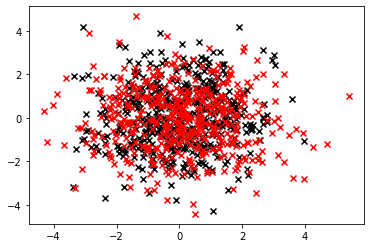

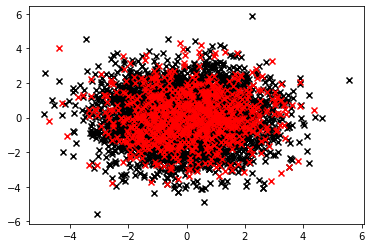

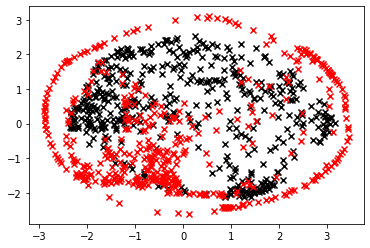

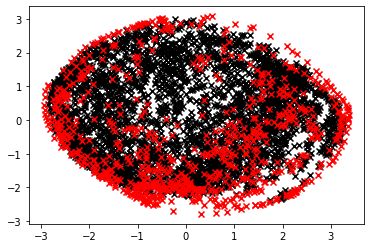

In [40]:
fault = 5
show_fault(train_loader, test_loader, [fault])
show_feature_fault(feature_train_loader, feature_test_loader,[fault])